# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

data_path = 'dataset/Part02/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
        print(c)
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

Name
Sex
Ticket
Cabin
Embarked


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 梯度提升樹擬合後, 將結果依照重要性由高到低排序 (note : D27作業中'Ticket'是第一名特徵, 'Age'是數值特徵中排名最高者)
estimator = GradientBoostingClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.444256
Pclass      0.111886
Ticket      0.098597
Fare        0.087429
Name        0.082191
Age         0.073129
Cabin       0.071008
Embarked    0.012220
Parch       0.011532
SibSp       0.007752
dtype: float64

## 先用梯度提升機對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [4]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8204569706860838

In [5]:
# 高重要性特徵 + 梯度提升樹 
high_feature = list(feats[0:4].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8305504990270542

正確率確實上升

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

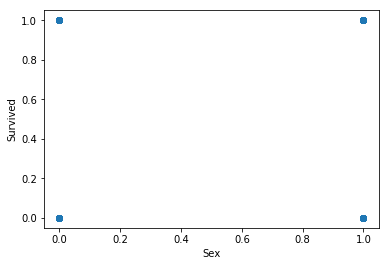

In [81]:
# 觀察重要特徵與目標的分布
# 第一名 : Sex              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=df['Sex'], y=train_Y, fit_reg=False)
plt.show()

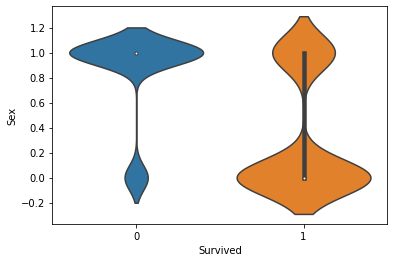

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x=train_Y, y=df['Sex'], fit_reg=False, scale="width")
plt.show()

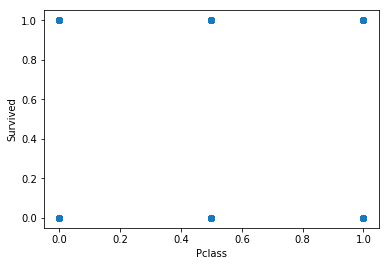

In [82]:
# 第二名 : PClass       
sns.regplot(x=df['Pclass'], y=train_Y, fit_reg=False)
plt.show()

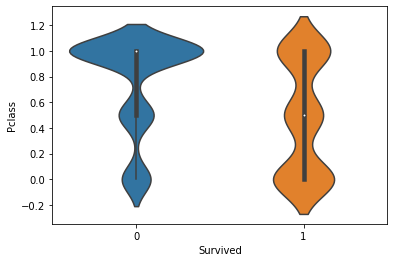

In [7]:
# 第二名 : Ticket       
sns.violinplot(x=train_Y, y=df['Pclass'], fit_reg=False)
plt.show()

In [86]:
# 製作新特徵看效果
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Pclass_sex'] = df['Pclass']*df['Sex']
df['Pclass+sex'] = df['Pclass'] + df['Sex']/2
df['Pclass/sex'] = df['Pclass']/(df['Sex']+1)*2
df['sex/Pclass'] = df['Sex']/(df['Pclass']+1)*2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8271775846899075

In [87]:
estimator = GradientBoostingClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex           0.365434
Ticket        0.096973
Fare          0.087863
Name          0.079339
Age           0.078750
sex/Pclass    0.069898
Cabin         0.068048
Pclass+sex    0.051445
Pclass        0.038068
Pclass/sex    0.031978
Parch         0.011558
Embarked      0.010326
SibSp         0.007837
Pclass_sex    0.002483
dtype: float64

多餘的特徵帶來噪音（Pclass_sex），導致準確率下降

In [88]:
df = df.drop(['Pclass_sex'],axis = 1)
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8294122215614159

仍然不比原本的模型的準確率高。特徵重組出的新特徵並沒有增益。